**COMP6579001 - Big Data Processing**
<br>
<br>
**LD01 - Group 8:**
<br>
2702225612 - Albert Tandy Harison
<br>
2702218102 - Augusto Jonathan Chandra
<br>
2702225846 - Calvin Suharjono
<br>
2702255842 - Cindy Noveiren
<br>
2702254543 - Jazzlyn Amelia Lim
<br>
2702218935 - Kelson Vincien



# Big Data Analysis: Prediksi Penyakit Kardiovaskular Menggunakan Machine Learning Berbasis Apache Spark

In [ ]:
# Delete all files in Colab /content
!rm -rf /content/*

In [ ]:
# Import libraries
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, lit, when, udf, array
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("CardiovascularDiseasePrediction") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Data Collection

Dataset yang digunakan dalam menganalisis faktor penyakit kardiovaskular adalah Cardiovascular Disease Dataset yang diperoleh dari Kaggle dan terdiri atas 70.000 catatan pasien. Dataset ini menyediakan informasi dari pasien, yaitu fitur objektif – usia, jenis kelamin, tinggi badan dan berat badan, fitur pemeriksaan – tekanan darah sistolik dan diastolik, kadar kolesterol, dan kadar glukosa, fitur objektif – kebiasaan merokok, konsumsi alkohol dan aktivitas fisik , dan apakah pasien tersebut merupakan kardiovaskular atau tidak.

https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

In [ ]:
# Upload dataset
from google.colab import files
files.upload()

# Read the CSV into a Spark DataFrame
data_spark = spark.read.csv('cardio_data.csv', sep=';', header=True, inferSchema=True)

# Preview the first few rows of the data
data_spark.show(5)

# Display statistical summary for all features except the ID column
data_spark.drop('id').describe().show()

Saving cardio_data.csv to cardio_data.csv
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 5 rows

+-------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+--------

# Data Cleaning


Pembersihan data ini bertujuan untuk memastikan data yang digunakan pada proses analisis dan pelatihan model machine learning bersih, valid dan konsisten. Pembersihan data dilakukan dengan menghapus kolom yang tidak relevan dengan analisis, konversi seperti hari ke tahun pada kolom age, dan nama kolom diubah menjadi deskriptif agar mudah dibaca.

Setelah itu, dilakukan visualisasi pada data numerik dengan histogram dan boxplot dari 10% sampel data dan dikonversi ke Pandas DataFrame untuk **mendeteksi outlier pada data**. Outlier yang dideteksi kemudian dibersihkan dengan metode Interquartile Range (IQR) pada kolom data kontinu dengan menghapus nilai-nilai diluar rentang normal.

Kemudian dilakukan validasi untuk memastikan nilai-nilai pada kolom kategori hanya berisi angka valid sesuai dengan kategorinya dan kolom biner hanya mengandung 0 dan 1. Setelah itu, **missing values dan data duplikat dihapus** untuk menghindari error dan bias pada hasil analisis.




In [ ]:
# Drop 'id' column
data_spark = data_spark.drop('id')

# Convert age from days to years for better understanding and analysis
data_spark = data_spark.withColumn('age', col('age') / 365.25)
data_spark.select('age').show(5)

# Rename columns for better understanding
data_spark = data_spark.withColumnRenamed('ap_hi', 'systolic_b_pressure') \
                       .withColumnRenamed('ap_lo', 'diastolic_b_pressure') \
                       .withColumnRenamed('gluc', 'glucose') \
                       .withColumnRenamed('alco', 'alcohol') \
                       .withColumnRenamed('active', 'physically_active') \
                       .withColumnRenamed('cardio', 'cardio_disease')

+------------------+
|               age|
+------------------+
| 50.35728952772074|
| 55.38124572210815|
| 51.62765229295003|
| 48.24914442162902|
|47.841204654346335|
+------------------+
only showing top 5 rows



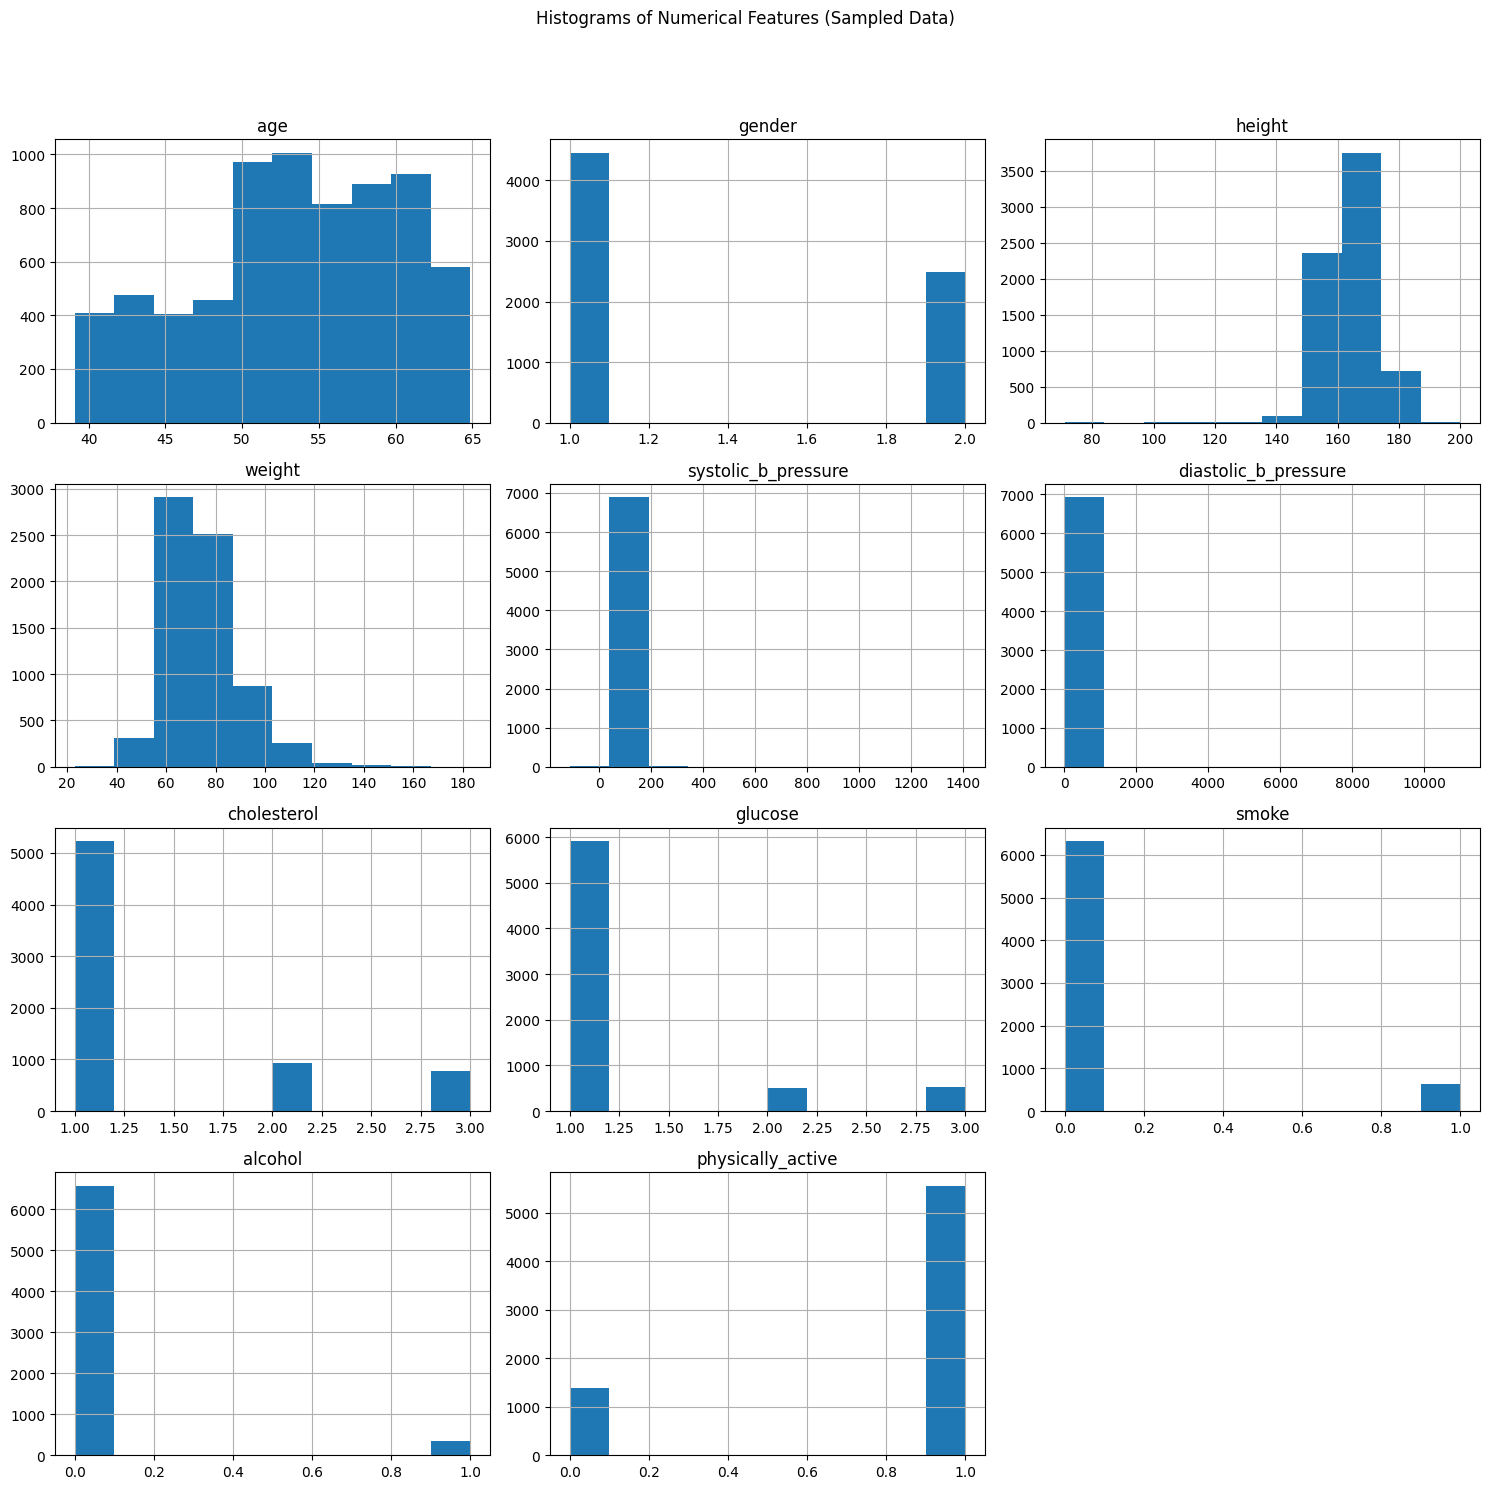

In [ ]:
# Plot histograms for all numerical columns in the DataFrame
numerical_cols = [f.name for f in data_spark.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType)) and f.name not in ['cardio_disease']]
if numerical_cols:
    # Convert a sample to Pandas for plotting
    pandas_sample = data_spark.select(numerical_cols).sample(False, 0.1, 42).toPandas() # Sample 10%
    if not pandas_sample.empty:
        pandas_sample.hist(figsize=(15, 15))
        plt.suptitle("Histograms of Numerical Features (Sampled Data)", y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()
    del pandas_sample # Free memory

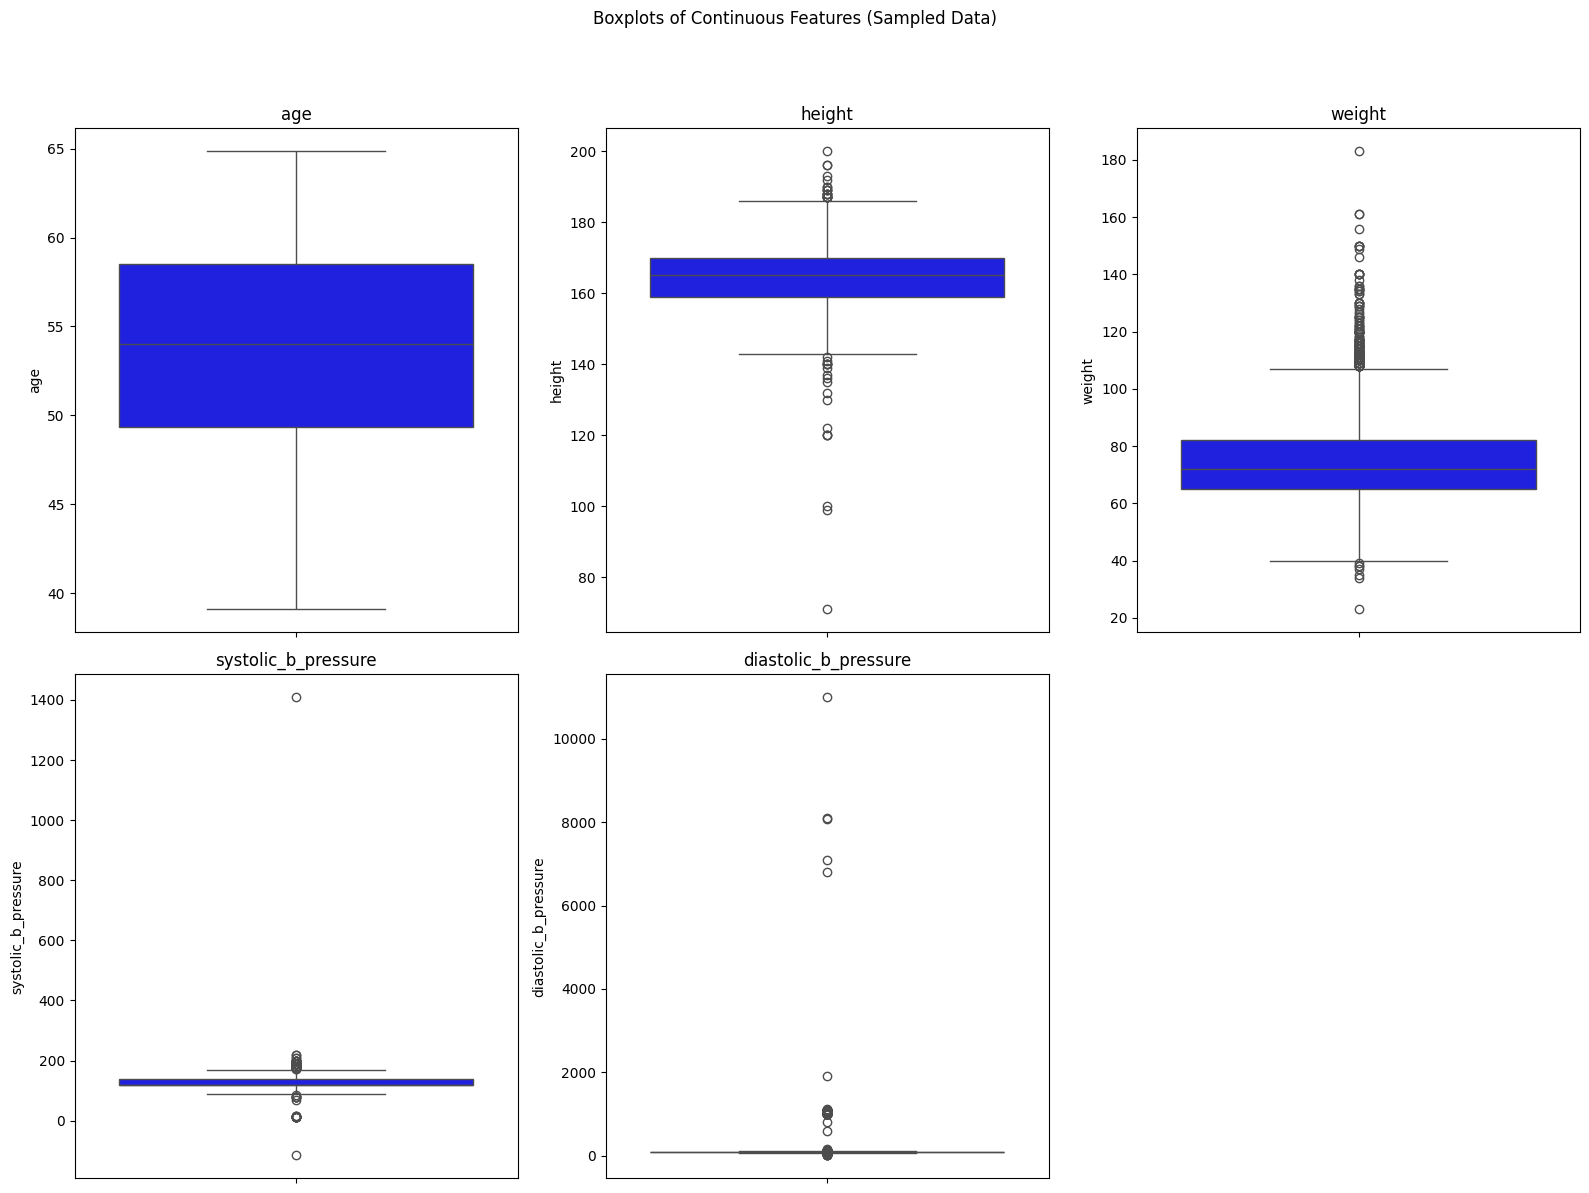

In [ ]:
# Display boxplots for continuous data columns
cols_for_boxplot = ['age', 'height', 'weight', 'systolic_b_pressure', 'diastolic_b_pressure']
ncols = 3
nrows = 2

pandas_sample_for_boxplot = data_spark.select(cols_for_boxplot).sample(False, 0.1, 42).toPandas()
if not pandas_sample_for_boxplot.empty:
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 12))
    count = 0
    for i in range(nrows):
        for j in range(ncols):
            if count < len(cols_for_boxplot):
                sns.boxplot(y=pandas_sample_for_boxplot[cols_for_boxplot[count]], ax=ax[i][j], color='blue')
                ax[i][j].set_title(cols_for_boxplot[count])
                count += 1
            else:
                ax[i][j].axis('off')
    plt.suptitle("Boxplots of Continuous Features (Sampled Data)", y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
del pandas_sample_for_boxplot # Free memory

In [ ]:
# Clean outlier (continuous data) with IQR
def remove_outliers_iqr_spark(df_spark, column):
    quantiles = df_spark.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_spark.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

continuous_columns = ['age', 'height', 'weight', 'systolic_b_pressure', 'diastolic_b_pressure']

for col_name in continuous_columns:
    data_spark = remove_outliers_iqr_spark(data_spark, col_name)

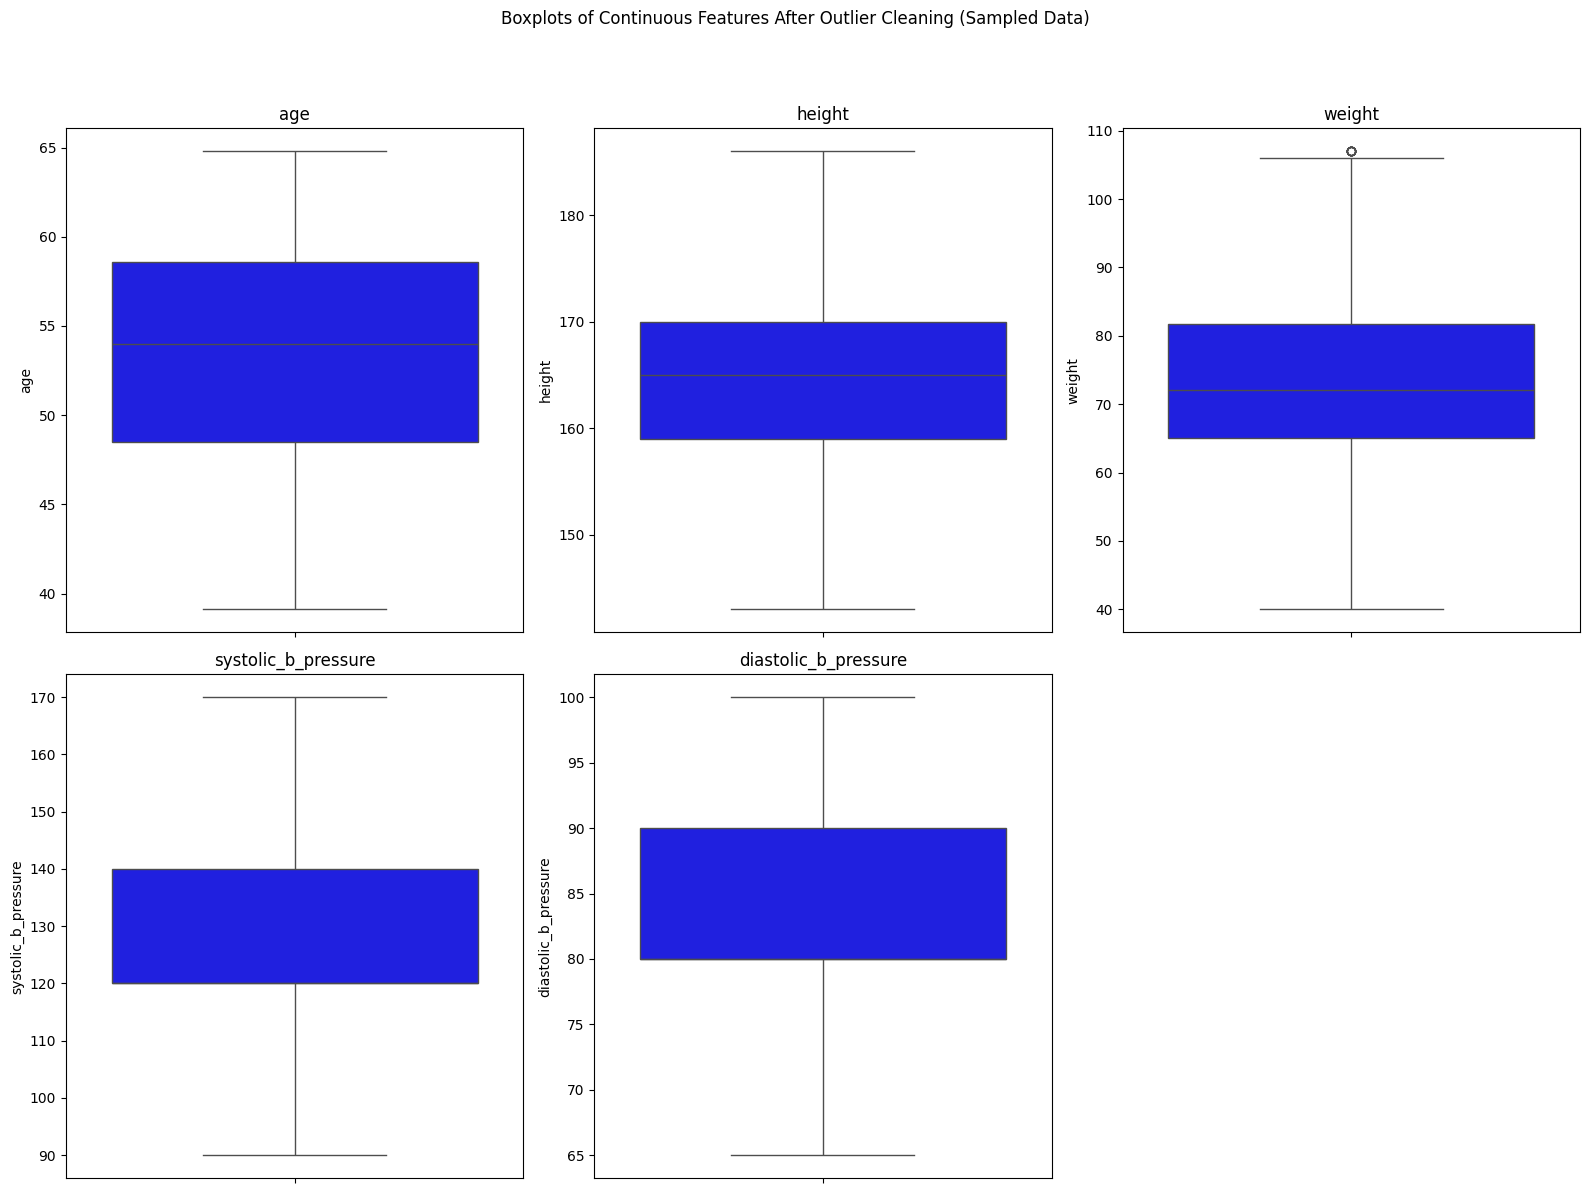

In [ ]:
# Display boxplots after cleaning outlier
pandas_sample_after_cleaning = data_spark.select(cols_for_boxplot).sample(False, 0.1, 42).toPandas()
if not pandas_sample_after_cleaning.empty:
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 12))
    count = 0
    for i in range(nrows):
        for j in range(ncols):
            if count < len(cols_for_boxplot):
                sns.boxplot(y=pandas_sample_after_cleaning[cols_for_boxplot[count]], ax=ax[i][j], color='blue')
                ax[i][j].set_title(cols_for_boxplot[count])
                count += 1
            else:
                ax[i][j].axis('off')
    plt.suptitle("Boxplots of Continuous Features After Outlier Cleaning (Sampled Data)", y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
del pandas_sample_after_cleaning # Free memory

In [ ]:
# Validate categorical data (1, 2, or 3)
data_spark = data_spark.filter(col('cholesterol').isin([1, 2, 3]))
data_spark = data_spark.filter(col('glucose').isin([1, 2, 3]))
data_spark = data_spark.filter(col('gender').isin([1, 2]))

# Validate binary categorical data (0 or 1)
binary_columns = ['smoke', 'alcohol', 'physically_active', 'cardio_disease']
for col_name in binary_columns:
    data_spark = data_spark.filter(col(col_name).isin([0, 1]))

In [ ]:
# Drop missing values
data_spark = data_spark.dropna()
print("Missing values per column (should be 0 after dropna):")
data_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in data_spark.columns]).show()

# Drop duplicated data
data_spark = data_spark.drop_duplicates()
print("Number of duplicate rows (should be 0 after drop_duplicates):")
print(data_spark.count() - data_spark.distinct().count())

Missing values per column (should be 0 after dropna):
+---+------+------+------+-------------------+--------------------+-----------+-------+-----+-------+-----------------+--------------+
|age|gender|height|weight|systolic_b_pressure|diastolic_b_pressure|cholesterol|glucose|smoke|alcohol|physically_active|cardio_disease|
+---+------+------+------+-------------------+--------------------+-----------+-------+-----+-------+-----------------+--------------+
|  0|     0|     0|     0|                  0|                   0|          0|      0|    0|      0|                0|             0|
+---+------+------+------+-------------------+--------------------+-----------+-------+-----+-------+-----------------+--------------+

Number of duplicate rows (should be 0 after drop_duplicates):
0


# Feature Engineering

Feature engineering dilakukan untuk **menambahkan informasi atau fitur baru** yang dapat diekstraksi dari dataset. Fitur-fitur baru didapatkan dari variabel pada tabel, seperti BMI dapat mengukur status gizi, kategorisasi tekanan darah, pengelompokan usia, dan interaksi antar variabel seperti merokok dan konsumsi alkohol, kolesterol dan BMI, dan aktivitas fisik seseorang.

In [ ]:
# Calculate BMI
data_spark = data_spark.withColumn('bmi', col('weight') / ((col('height') / 100) ** 2))

# Blood pressure categorization
data_spark = data_spark.withColumn(
    'blood_pressure_category',
    when((col('systolic_b_pressure') < 120) & (col('diastolic_b_pressure') < 80), 'normal')
    .when(((col('systolic_b_pressure') >= 120) & (col('systolic_b_pressure') < 140)) | \
          ((col('diastolic_b_pressure') >= 80) & (col('diastolic_b_pressure') < 90)), 'prehypertension')
    .when((col('systolic_b_pressure') >= 140) | (col('diastolic_b_pressure') >= 90), 'hypertension')
    .otherwise('unknown')
)

# Age grouping
age_group_udf = udf(lambda age: '<30' if age < 30 else ('30-44' if 30 <= age < 45 else ('45-59' if 45 <= age < 60 else '60+')), StringType())
data_spark = data_spark.withColumn('age_group', age_group_udf(col('age')))

# Interaction between smoking and alcohol
data_spark = data_spark.withColumn('smoke_and_alcohol', ((col('smoke') == 1) & (col('alcohol') == 1)).cast(IntegerType()))

# Systolic/Diastolic blood pressure ratio
data_spark = data_spark.withColumn('pressure_ratio', col('systolic_b_pressure') / col('diastolic_b_pressure'))

# Interaction between cholesterol and BMI
data_spark = data_spark.withColumn('cholesterol_bmi_interaction', col('cholesterol') * col('bmi'))

# Height-to-weight ratio
data_spark = data_spark.withColumn('height_weight_ratio', col('height') / col('weight'))

# Interaction between physical activity and cardiovascular disease
data_spark = data_spark.withColumn('lifestyle_impact', ((col('physically_active') == 1) & (col('cardio_disease') == 1)).cast(IntegerType()))

# Check new features
data_spark.show(5)

+-----------------+------+------+------+-------------------+--------------------+-----------+-------+-----+-------+-----------------+--------------+------------------+-----------------------+---------+-----------------+--------------+---------------------------+-------------------+----------------+
|              age|gender|height|weight|systolic_b_pressure|diastolic_b_pressure|cholesterol|glucose|smoke|alcohol|physically_active|cardio_disease|               bmi|blood_pressure_category|age_group|smoke_and_alcohol|pressure_ratio|cholesterol_bmi_interaction|height_weight_ratio|lifestyle_impact|
+-----------------+------+------+------+-------------------+--------------------+-----------+-------+-----+-------+-----------------+--------------+------------------+-----------------------+---------+-----------------+--------------+---------------------------+-------------------+----------------+
|58.32991101984942|     2|   157|  51.0|                120|                  80|          1|      1

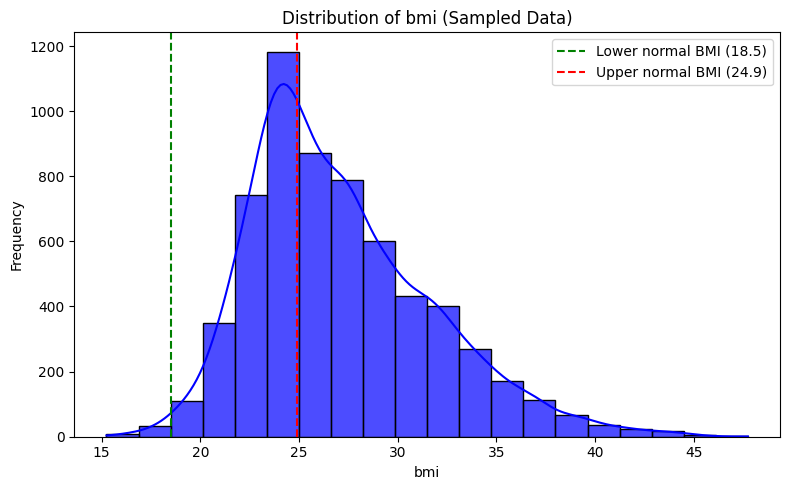

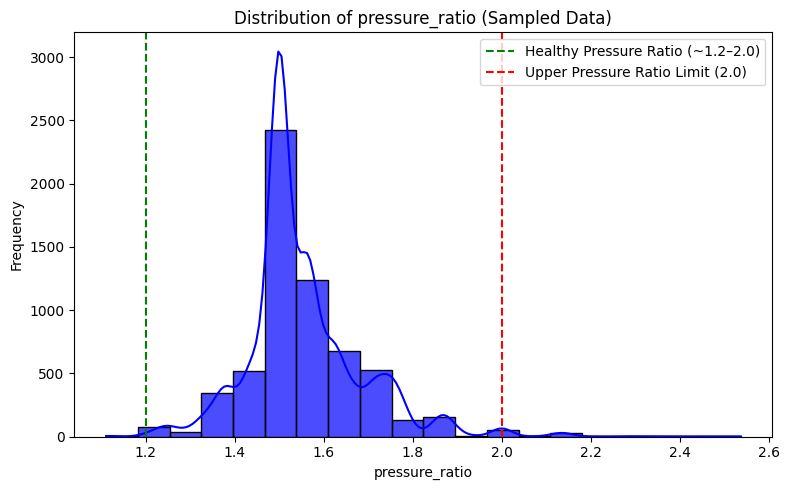

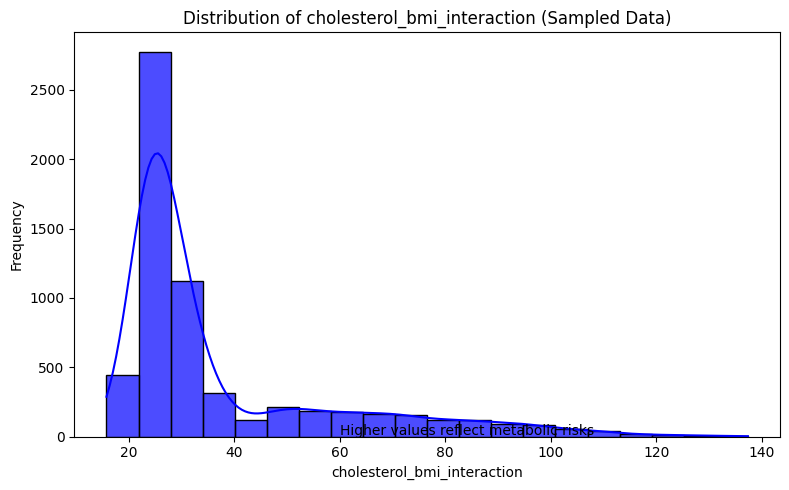

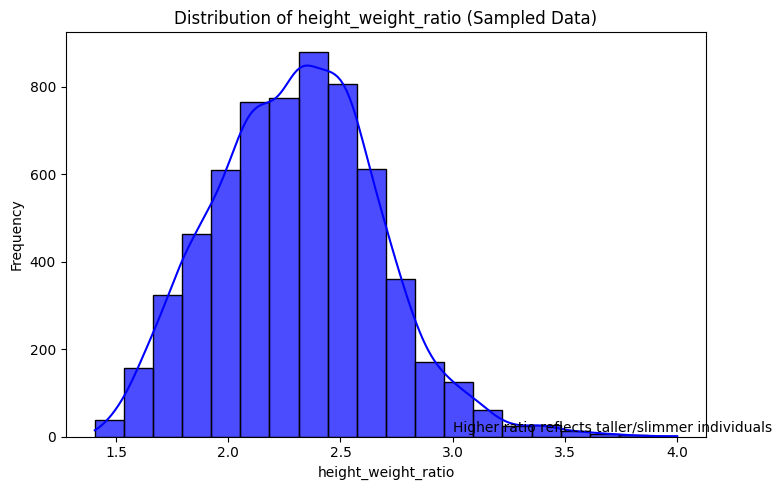

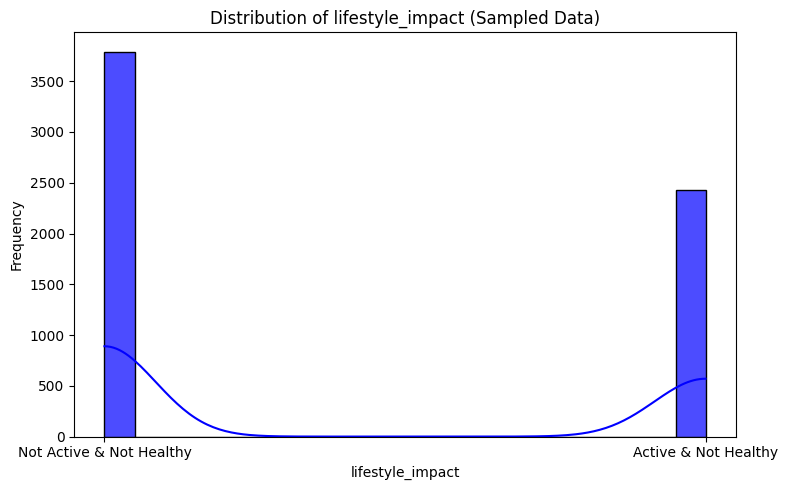

In [ ]:
# Plot distribution chart for each newly added feature
new_features = ['bmi', 'pressure_ratio', 'cholesterol_bmi_interaction',
                'height_weight_ratio', 'lifestyle_impact']

pandas_sample_new_features = data_spark.select(new_features).sample(False, 0.1, 42).toPandas()
if not pandas_sample_new_features.empty:
    for feature in new_features:
        plt.figure(figsize=(8, 5))
        sns.histplot(pandas_sample_new_features[feature], kde=True, bins=20, color="blue", alpha=0.7)
        plt.title(f'Distribution of {feature} (Sampled Data)')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

        # Add annotations to explain feature characteristics
        if feature == 'bmi':
            plt.axvline(x=18.5, color='green', linestyle='--', label='Lower normal BMI (18.5)')
            plt.axvline(x=24.9, color='red', linestyle='--', label='Upper normal BMI (24.9)')
            plt.legend()
        elif feature == 'pressure_ratio':
            plt.axvline(x=1.2, color='green', linestyle='--', label='Healthy Pressure Ratio (~1.2–2.0)')
            plt.axvline(x=2.0, color='red', linestyle='--', label='Upper Pressure Ratio Limit (2.0)')
            plt.legend()
        elif feature == 'cholesterol_bmi_interaction':
            plt.annotate('Higher values reflect metabolic risks',
                         xy=(50, 5), xytext=(60, 10))
        elif feature == 'height_weight_ratio':
            plt.annotate('Higher ratio reflects taller/slimmer individuals',
                         xy=(2.5, 5), xytext=(3, 10))
        elif feature == 'lifestyle_impact':
            plt.xticks([0, 1], ['Not Active & Not Healthy', 'Active & Not Healthy'])

        plt.tight_layout()
        plt.show()
    del pandas_sample_new_features # Free memory

# Feature Selection

Feature selection dilakukan untuk memilih atribut atau variabel yang relevan dengan variabel target. Hubungan setiap fitur numerik dihitung menggunakan metode pairwise–Pearson correlation pada Spark. Hasil yang memiliki nilai lemah dari hasil perhitungan ini, menunjukan bahwa hubungan variabel tersebut dengan variabel target lemah sehingga akan **dihapus** untuk **mengurangi distraksi noise** dari informasi yang kurang penting, dimana korelasi antar fitur ini akan divisualisasi menggunakan heatmap.

In [ ]:
# Display the correlations of all features with the target variable 'cardio_disease'
print("Calculating correlations (pairwise in Spark):")
for col_name in data_spark.columns:
    if col_name != 'cardio_disease' and isinstance(data_spark.schema[col_name].dataType, (DoubleType, IntegerType)):
        correlation_value = data_spark.stat.corr(col_name, 'cardio_disease')
        print(f"Correlation between {col_name} and cardio_disease: {correlation_value:.3f}")

Calculating correlations (pairwise in Spark):
Correlation between age and cardio_disease: 0.237
Correlation between gender and cardio_disease: -0.005
Correlation between height and cardio_disease: -0.028
Correlation between weight and cardio_disease: 0.162
Correlation between systolic_b_pressure and cardio_disease: 0.432
Correlation between diastolic_b_pressure and cardio_disease: 0.336
Correlation between cholesterol and cardio_disease: 0.218
Correlation between glucose and cardio_disease: 0.086
Correlation between smoke and cardio_disease: -0.022
Correlation between alcohol and cardio_disease: -0.012
Correlation between physically_active and cardio_disease: -0.038
Correlation between bmi and cardio_disease: 0.179
Correlation between smoke_and_alcohol and cardio_disease: -0.022
Correlation between pressure_ratio and cardio_disease: 0.211
Correlation between cholesterol_bmi_interaction and cardio_disease: 0.245
Correlation between height_weight_ratio and cardio_disease: -0.177
Correlat

In [ ]:
# Drop features with low importance, weak correlation, or high multicollinearity
features_to_drop_initial = [
    'gender', 'height', 'smoke', 'alcohol',
    'physically_active', 'smoke_and_alcohol',
    'height_weight_ratio'
]

features_to_drop_initial = [col for col in features_to_drop_initial if col in data_spark.columns]

print("Features to drop (initial selection):", features_to_drop_initial)
print(" ")

data_selected_spark = data_spark.drop(*features_to_drop_initial)

print("Remaining features after initial feature selection:")
print(data_selected_spark.columns)

Features to drop (initial selection): ['gender', 'height', 'smoke', 'alcohol', 'physically_active', 'smoke_and_alcohol', 'height_weight_ratio']
 
Remaining features after initial feature selection:
['age', 'weight', 'systolic_b_pressure', 'diastolic_b_pressure', 'cholesterol', 'glucose', 'cardio_disease', 'bmi', 'blood_pressure_category', 'age_group', 'pressure_ratio', 'cholesterol_bmi_interaction', 'lifestyle_impact']


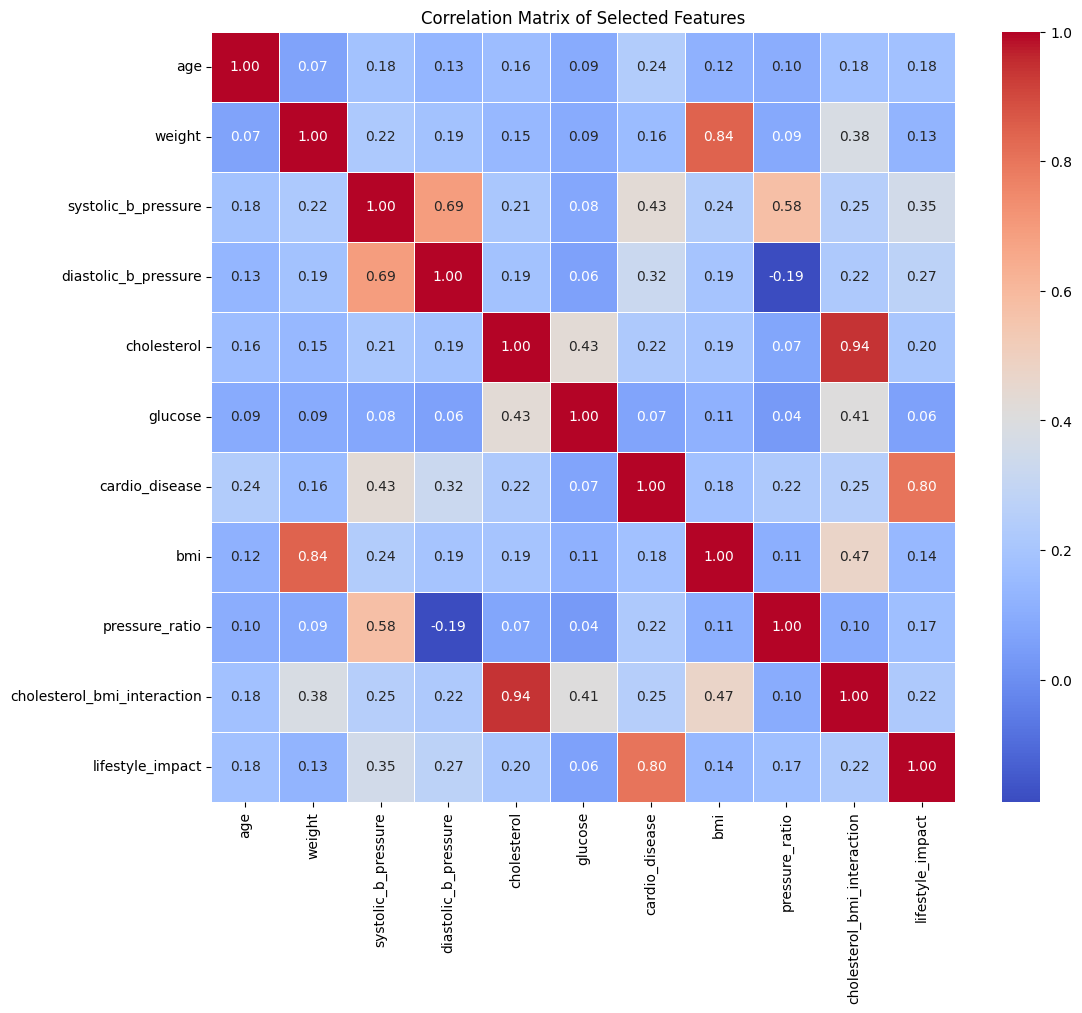

In [ ]:
# Correlation Matrix

selected_numeric_cols = [
    f.name for f in data_selected_spark.schema.fields
    if isinstance(f.dataType, (DoubleType, IntegerType))
]

sample_ratio = 0.1
pandas_df_for_corr = data_selected_spark.select(selected_numeric_cols).sample(False, sample_ratio, seed=42).toPandas()

if not pandas_df_for_corr.empty:
    correlation_matrix = pandas_df_for_corr.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=.5
    )
    plt.title('Correlation Matrix of Selected Features')
    plt.show()
else:
    print("DataFrame sampel kosong. Tidak dapat menghitung matriks korelasi.")

Dari heatmap yang telah diperoleh dapat dilakukan analisis korelasi atau hubungan antar fitur dalam dataset. Heatmap yang diperoleh merupakan heatmap yang sudah dilakukan feature selection sehingga dari heatmap ini akan lebih mudah untuk dilihat **faktor-faktor yang menyebabkan individu terkena kardiovaskular**.

Hubungan setiap variabel ditunjukan dengan rentang -1 hingga 1, dimana nilai yang mendekati 1 menunjukkan hubungan yang kuat dan angka mendekati -1 menunjukan hubungan antar variabel yang lemah.
Berdasarkan heatmap yang ada maka dapat dilihat korelasi yang tinggi antara cholesterol dengan cholesterol_bmi_interaction  dengan nilai 0.94 kemudian variabel weight dan bmi dengan nilai 0.84. Nilai yang mendekati satu ini menunjukkan adanya multikolinearitas yang butuh perhatian khusus karena dapat ambigu pada model ketika mengklasifikasi.

Kemudian beberapa variabel menunjukan hubungan yang erat dengan cardio_disease sebagai variabel utama, hubungan erat dengan variabel utama ini menunjukan bahwa variabel tersebut memiliki pengaruh terhadap variabel utama. Sebagai contoh **systolic_b_pressure** memiliki hubungan 0.43 yang menjelaskan bahwa **tekanan darah memiliki pengaruh seberapa besar individu dapat terpapar kardiovaskular**.


# Data Preprocessing

Pada proses ini, dilakukan pengkodean pada kolom non-numerik seperti kategori tekanan darah dan kelompok usia menggunakan One-Hot Encoding yang menggunakan “StringIndexer” untuk mengubah kategori menjadi angka, lalu OneHotEncoder untuk menghasilkan vektor biner.

Selanjutnya, fitur numerik kontinu seperti berat, tinggi, BMI, tekanan darah, dan lainnya distandarisasi menggunakan StandardScaler, kecuali fitur-fitur bersifat kategorikal atau sudah berbentuk biner.

Semua fitur yang telah diencoding dan diskalakan digabungkan menggunakan VectorAssembler menjadi satu vektor fitur. Dataset kemudian dibagi menjadi dua yaitu train (80%) dan test (20%).

In [ ]:
# Perform One-Hot Encoding on new non-numeric feature columns
non_numeric_columns_selected = [f.name for f in data_selected_spark.schema.fields if isinstance(f.dataType, StringType)]
print("Non-numeric columns for encoding:", non_numeric_columns_selected)

indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed", handleInvalid="keep") for column in non_numeric_columns_selected]
encoders = [OneHotEncoder(inputCol=column + "_indexed", outputCol=column + "_encoded", dropLast=True) for column in non_numeric_columns_selected]

pipeline_stages_encoding = indexers + encoders
pipeline_encoding = Pipeline(stages=pipeline_stages_encoding)
data_encoded_final_spark = pipeline_encoding.fit(data_selected_spark).transform(data_selected_spark)

cols_to_drop_after_encoding_final = non_numeric_columns_selected + [col + "_indexed" for col in non_numeric_columns_selected]
data_encoded_final_spark = data_encoded_final_spark.drop(*cols_to_drop_after_encoding_final)


# Standardize numeric continuous variables
features_to_exclude_from_scaling = ['cholesterol', 'glucose', 'lifestyle_impact']

numeric_features_final = [
    f.name for f in data_encoded_final_spark.schema.fields
    if isinstance(f.dataType, (DoubleType, IntegerType)) and
       f.name != 'cardio_disease' and
       f.name not in features_to_exclude_from_scaling
]

print("Numeric features selected for standardization:", numeric_features_final)
assembler_numeric = VectorAssembler(inputCols=numeric_features_final, outputCol="numeric_features_assembled")
scaler_final = StandardScaler(inputCol="numeric_features_assembled", outputCol="scaled_numeric_features", withStd=True, withMean=True)

# Combine scaled numeric features with already one-hot encoded categorical features
final_features_to_assemble = ['scaled_numeric_features'] + \
                             [f.name for f in data_encoded_final_spark.schema.fields if f.name.endswith('_encoded')] + \
                             features_to_exclude_from_scaling

assembler_final = VectorAssembler(inputCols=final_features_to_assemble, outputCol="features")

# Pipeline for preprocessing
preprocessing_pipeline = Pipeline(stages=[
    assembler_numeric,
    scaler_final,
    assembler_final
])

preprocessor_model = preprocessing_pipeline.fit(data_encoded_final_spark)
processed_data_spark = preprocessor_model.transform(data_encoded_final_spark)

Non-numeric columns for encoding: ['blood_pressure_category', 'age_group']
Numeric features selected for standardization: ['age', 'weight', 'systolic_b_pressure', 'diastolic_b_pressure', 'bmi', 'pressure_ratio', 'cholesterol_bmi_interaction']


In [ ]:
# Split dataset (80% train, 20% test)
target_col = 'cardio_disease'

train_data_spark, test_data_spark = processed_data_spark.randomSplit([0.8, 0.2], seed=42)

# Print the shape (count) of each split
print("X_train shape (count):", train_data_spark.count())
print("X_test shape (count):", test_data_spark.count())
print(" ")

# Print the class distribution in the training and testing sets
print("\nClass distribution in y_train (Spark):")
train_data_spark.groupBy(target_col).count().show()

print("\nClass distribution in y_test (Spark):")
test_data_spark.groupBy(target_col).count().show()

X_train shape (count): 49834
X_test shape (count): 12644
 

Class distribution in y_train (Spark):
+--------------+-----+
|cardio_disease|count|
+--------------+-----+
|             1|24504|
|             0|25330|
+--------------+-----+


Class distribution in y_test (Spark):
+--------------+-----+
|cardio_disease|count|
+--------------+-----+
|             1| 6359|
|             0| 6285|
+--------------+-----+



# Modelling

Setelah dilakukan proses preprocessing maka data yang ada sudah dapat dimasukan kedalam model machine learning. Pada penelitian ini kami menggunakan tiga model machine learning dan membandingkan model ketiga model machine learning ini untuk mengetahui model machine learning yang paling optimal dalam mengidentifikasi kardiovaskular. Model machine learning yang kami gunakan adalah **Logistic Regression, Random Forest, dan Gradient-Boost Tree (GBTClassifier)**.

Setiap model machine learning yang ada dikonfigurasi menggunkaan hyperparameter “ParamGridBuilder” dan dilatih menggunakan Cross Validation sebanyak 2 lipatan. Proses ini bertujuan untuk mendapatkan parameter terbaik untuk melatih.

Kemudian, evaluasi dilakukan dengan menggunakan Spark MLlib untuk menghitung train accuracy dan test accuracy. Kemudian dilakukan evaluasi dengan Sklearn dimana hasil prediksi dari Spark dikonversi ke Pandas DataFrame kemudian menggunakan sklearn untuk menghitung precision, recall dan F1-Score.


In [ ]:
# Define selected models and hyperparameters
models_spark = {
    'Logistic Regression': {
        'model': LogisticRegression(featuresCol="features", labelCol=target_col, maxIter=50),
        'params': ParamGridBuilder() \
            .addGrid(LogisticRegression.regParam, [0.01, 0.1]) \
            .build()
    },
    'Random Forest': {
        'model': RandomForestClassifier(featuresCol="features", labelCol=target_col, seed=42),
        'params': ParamGridBuilder() \
            .addGrid(RandomForestClassifier.numTrees, [50, 100]) \
            .addGrid(RandomForestClassifier.maxDepth, [8, 12])
            .build()
    },
    'Gradient-Boosted Tree': {
        'model': GBTClassifier(featuresCol="features", labelCol=target_col, seed=42),
        'params': ParamGridBuilder() \
            .addGrid(GBTClassifier.maxDepth, [4, 6]) \
            .addGrid(GBTClassifier.maxIter, [20, 50]) \
            .build()
    }
}

In [ ]:
# Train models & evaluation
results_spark = []
all_test_predictions = {}

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")

for name, config in models_spark.items():
    print(f"\n--- Training {name} ---")

    cv = CrossValidator(estimator=config['model'],
                        estimatorParamMaps=config['params'],
                        evaluator=evaluator_accuracy,
                        numFolds=2,
                        seed=42)

    cv_model = cv.fit(train_data_spark)
    best_model_spark = cv_model.bestModel

    # Make predictions
    train_predictions = best_model_spark.transform(train_data_spark)
    test_predictions = best_model_spark.transform(test_data_spark)

    # Evaluate accuracy (Spark MLlib)
    train_acc = evaluator_accuracy.evaluate(train_predictions)
    test_acc = evaluator_accuracy.evaluate(test_predictions)

    # Convert predictions and labels to pandas
    test_labels_pandas = test_predictions.select(target_col).toPandas()
    test_preds_pandas = test_predictions.select("prediction").toPandas()

    # Sklearn metrics
    test_precision = precision_score(test_labels_pandas, test_preds_pandas, average='weighted', zero_division=0)
    test_recall = recall_score(test_labels_pandas, test_preds_pandas, average='weighted', zero_division=0)
    test_f1 = f1_score(test_labels_pandas, test_preds_pandas, average='weighted', zero_division=0)

    print(f"Best Parameters for {name}: {best_model_spark.extractParamMap()}")
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")
    print(f"Test Precision: {test_precision:.3f}")
    print(f"Test Recall: {test_recall:.3f}")
    print(f"Test F1-score: {test_f1:.3f}")

    results_spark.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1-score': test_f1
    })

    all_test_predictions[name] = test_predictions



--- Training Logistic Regression ---
Best Parameters for Logistic Regression: {Param(parent='LogisticRegression_bbcf3777d110', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_bbcf3777d110', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_bbcf3777d110', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_bbcf3777d110', name='featuresCol', doc='features column name.'): 'features', Param(parent='LogisticRegression_bbcf3777d110', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_bbcf3777d110', name='labelCol', doc='label column name.'): 'cardio_disease', Param(parent='Logistic

Plotting Confusion Matrix for Logistic Regression:


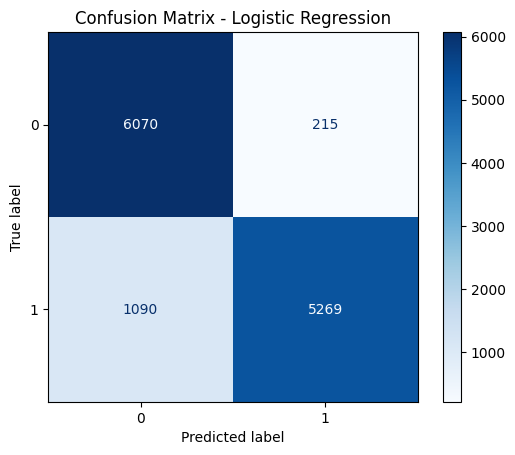

Plotting Confusion Matrix for Random Forest:


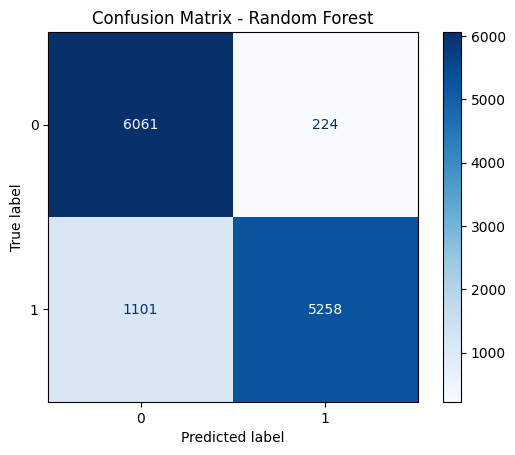

Plotting Confusion Matrix for Gradient-Boosted Tree:


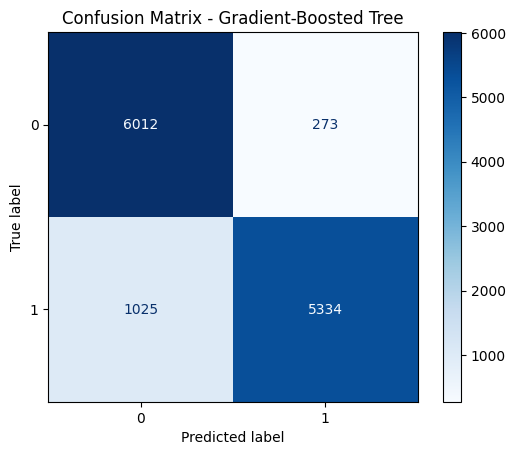

In [ ]:
# Confusion Matrix
first_model_key = list(all_test_predictions.keys())[0]
test_labels_pandas_for_reports = all_test_predictions[first_model_key].select(target_col).toPandas()

for name, test_preds_df_spark in all_test_predictions.items():
    print(f"Plotting Confusion Matrix for {name}:")
    test_preds_pandas = test_preds_df_spark.select("prediction").toPandas()

    cm = confusion_matrix(test_labels_pandas_for_reports, test_preds_pandas)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [ ]:
# Summary for Accuracy and Precision
results_data_spark = pd.DataFrame(results_spark)
print("\n--- Model Performance Summary (Accuracy & Precision) ---")
print(results_data_spark[['Model', 'Test Accuracy', 'Test Precision']].round(4))


--- Model Performance Summary (Accuracy & Precision) ---
                   Model  Test Accuracy  Test Precision
0    Logistic Regression         0.8968          0.9046
1          Random Forest         0.8952          0.9030
2  Gradient-Boosted Tree         0.8973          0.9031


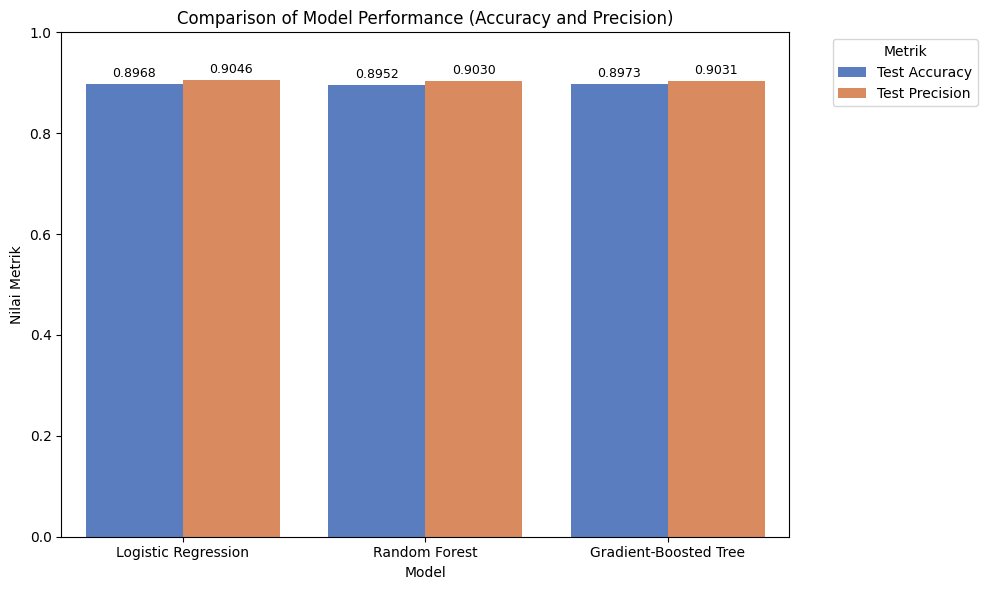

In [ ]:
# Plot Accuracy and Precision Comparison
metrics_to_plot = ['Test Accuracy', 'Test Precision']
df_plot = results_data_spark.set_index('Model').stack().reset_index()
df_plot.columns = ['Model', 'Metric', 'Value']

df_plot_filtered = df_plot[df_plot['Metric'].isin(metrics_to_plot)]

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='Value', hue='Metric', data=df_plot_filtered, palette='muted')

for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # hanya tampilkan label kalau > 0
        barplot.annotate(f'{height:.4f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         fontsize=9, color='black', xytext=(0, 3),
                         textcoords='offset points')

plt.title('Comparison of Model Performance (Accuracy and Precision)')
plt.ylim(0, 1)
plt.ylabel('Nilai Metrik')
plt.xlabel('Model')
plt.legend(title='Metrik', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Hasil akhir dari setiap model menunjukan bahwa ketiga model yang dibandingkan memiliki hasil yang bersaing satu sama lain. **Gradient-Boosted Tree** menjadi algoritma dengan akurasi dan precision **paling tinggi** mengungguli dua algoritma lainnya. Gradient-Boosted Tree mempunyai akurasi sebesar 89.73% dan precision 90.31% lebih unggul dibandingkan Logistic Regression dengan akurasi 89.68% dan 80.46% untuk precision. Random Forest juga menunjukan performa yang bersaing dengan akurasi 89.52% dan precision 90.30%. Hasil dari setiap model machine learning ini dapat dilihat pada grafik batang diatas.

Perbedaan performa antara Linear Regression, Random Forest, dan Gradient Boosting dalam memprediksi penyakit kardiovaskular dapat dipengaruhi cara kerja masing-masing model yang digunakan. Linear Regression mengasumsikan hubungan linier antara fitur dan target, sehingga kurang cocok untuk pola data yang kompleks dan sangat rentan terhadap outlier yang dapat menggeser hasil prediksi. Random Forest lebih tahan terhadap outlier pada data dan ketidak seimbangan data karena melakukan sampling acak, sehingga prediksi menjadi lebih stabil. Gradient Boosting memberikan hasil yang paling akurat, karena model dibangun secara bertahap dan fokus pada memperbaiki kesalahan sebelumnya. Namun, model ini lebih sensitif terhadap outlier dan variasi data jika tidak diatur dengan baik.

Dalam menghadapi data yang besar dan kompleks, Linear Regression seringkali kurang mampu menangkap pola non-linear yang ada, sedangkan Random Forest efektif karena paralelisasi dan pembagian data menjadi banyak pohon yang lebih kecil. Gradient Boosting, meskipun lebih lambat karena proses bertahap, mampu memodelkan hubungan kompleks dengan sangat baik. Perbedaan dalam kemampuan menangani outlier, ketidakseimbangan data, serta kestabilan terhadap perubahan data ini secara signifikan mempengaruhi keakuratan dan konsistensi ketiga model dalam prediksi penyakit kardiovaskular.

In [ ]:
# Stop spark session
spark.stop()